# Mixed Image Data Analysis

In [2]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

In [4]:
Aimg, Alab = DU.load_data("data/mnist_70000.h5")
Bimg, Blab = DU.load_data("data/grass2.hdf5")

Ximg = Aimg * 0.2 + Bimg * 0.8
Xlab = Alab

## Raw Data

The `grass1` dataset is a synthetic dataset created from 11 photos of grass.  The images are converted to grayscale, and each point corresponds to a random 28 x 28 tile cropped from one of these source images.

Category labels correspond to the number of the source image used (1-11).

Here is a sample of the data.  Each row corresponds to a source image.

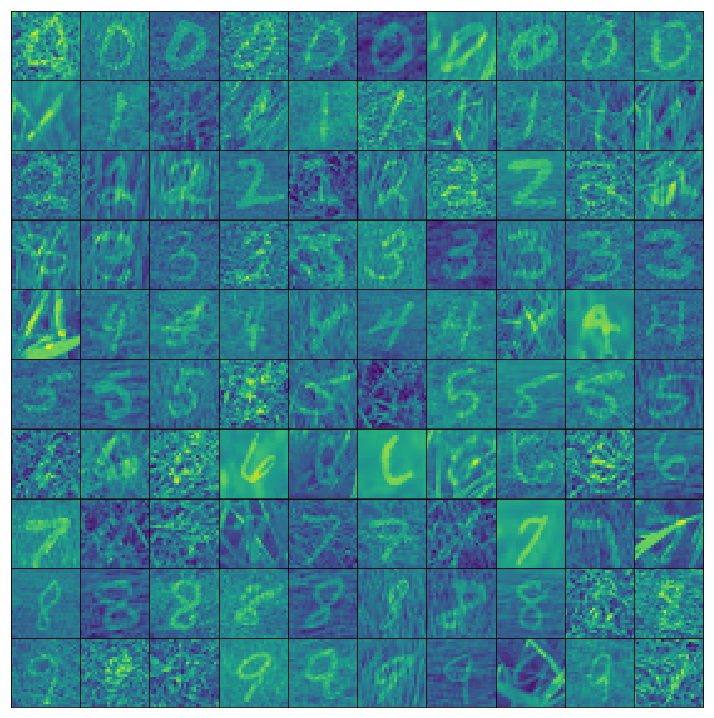

In [5]:
grouped = np.hstack([np.arange(70000)[Xlab==i][:10] for i in range(11)])
DU.show_data(Ximg[grouped], cols=10)

## Principal Components

We perform singular value decomposition of the covariance matrix to determine the principal components of the data.

### Explanation of variance

The following graph shows the relative magnitude of each principal component, and how much total variance is explained by the first $k$ principal components.

In [6]:
X, Xbar, CX = DU.normalize_image_data(Ximg)

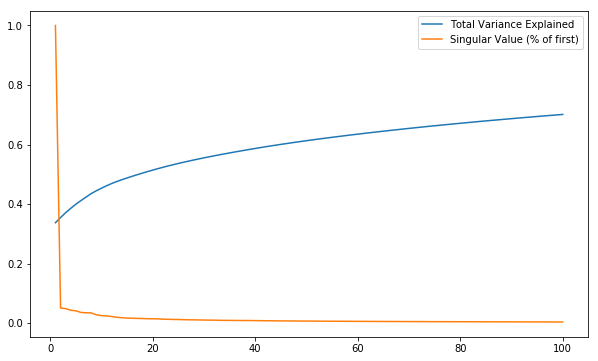

In [7]:
Xu, Xs, Xvt = np.linalg.svd(CX)
DU.graph_variance_explained(Xs)

* The first 50 principal components explain about 60% of the variance in the data.
* Additional principal components provide very modest gains in explaining more variance.

### Visualizing the Average Image

We have preprocessed our data to be zero mean across each pixel.

This is what the average image from this dataset looks like:

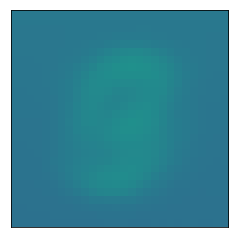

In [8]:
DU.show_img(DU.X_to_img(0, Xbar))

The average image has near-uniform intensity.

(Contrast with MNIST, where the average image looked more like a blurry digit.)

### Visualizing Principal Components

We can visualize each principal component as an image by rehaping the columns of $U$ to $28 \times 28$ and plotting them as images.

Because each PC constitutes a direction in pixel space, we view them with a diverging color scheme which makes it easy to see the positive and negative regions.

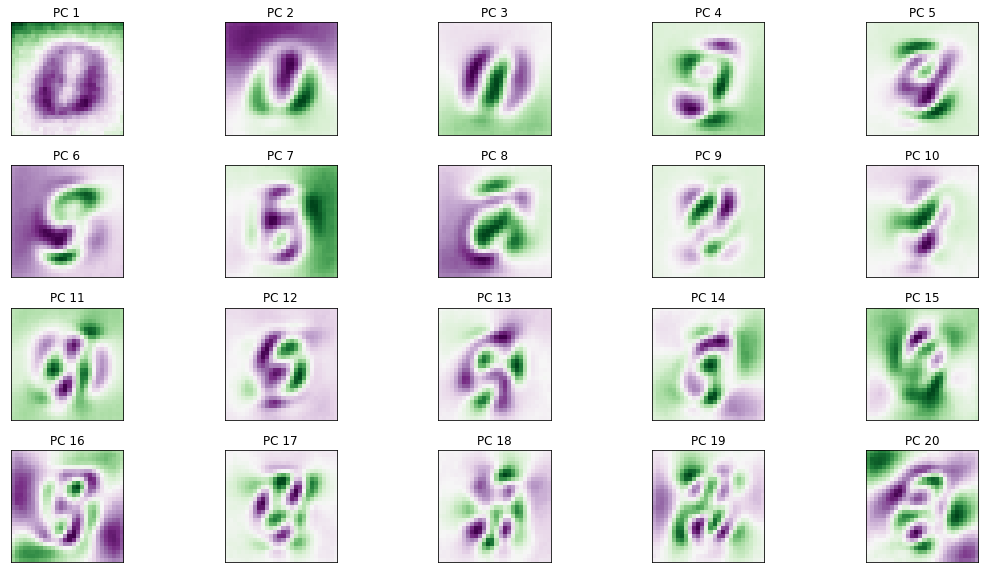

In [9]:
DU.show_pcs(Xu, 20)

The graph above shows the first 20 principal components.

* As with the MNIST data, we can see that the PCs begin simply, and increase in complexity.
* The PCs are clearly differ from the MNIST PCs (which were specialized for representing digits).
* These PCs are very general, and look suitable for representing almost any image (given enough of them).
* The patterns in these PCs resemble the basis of a 2-dimensional [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform), a basis often used in image compression.

### Determining the Subspace

We can attempt to visually estimate the dimension of the linear subspace for MNIST data by looking at dimensionally reduced images projected back into pixel space.

Here, we examine the quality of 20 random digits as they are projected into truncated PCA coordinates.

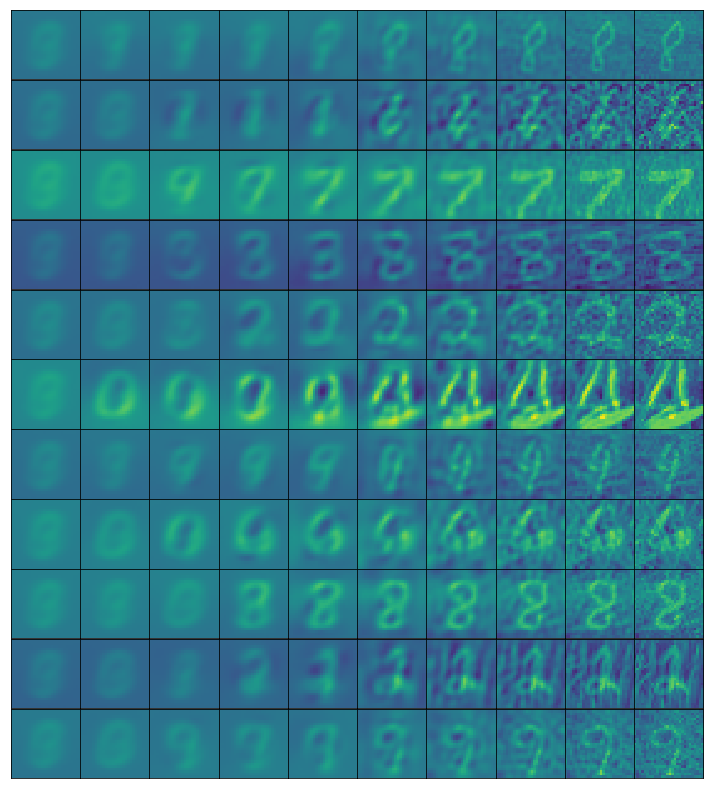

In [10]:
dims = [1, 2, 5, 10, 20, 50, 100, 200, 400, 784]

samp = X[:11]
Psamp = [(samp @ Xu[:,:k]) @ Xu.T[:k,:] for k in dims]

pcadigits = np.asarray(Psamp).transpose((1,0,2))

DU.show_data(DU.X_to_img(np.vstack(pcadigits), Xbar), cols=10)

In the image above, each row represents an original data point, and each column represents a level of PCA dimension reduction.

* Notice that the images smoothly transition from uniform intensity, to blurry, to sharp.
* It takes 100-200 principal components (or more) to reproduce an image tile with a texture that is recognizable as grass.


### Observations

We characterize the effects of using a limited number of components (roughly) as follows:

| Dimension | % Variance | Description                                   |
| --------- | ---------- | --------------------------------------------- |
| 1         | 10%        | average illumination of image is established  |
| 10-20     | 50-55%     | light/dark regions appear within image        |
| 100+      | 65%        | identifiable grass texture begins to resolve  |
| 400+      | > 85%      | image becomes "sharp"                         |


## Embeddings

### PCA

We can look at the relationships between the most significant prinipal components by creating a scatterplot matrix.

Here, we show a scatterplot matrix of PC 1-5, with histograms on the diagonal.

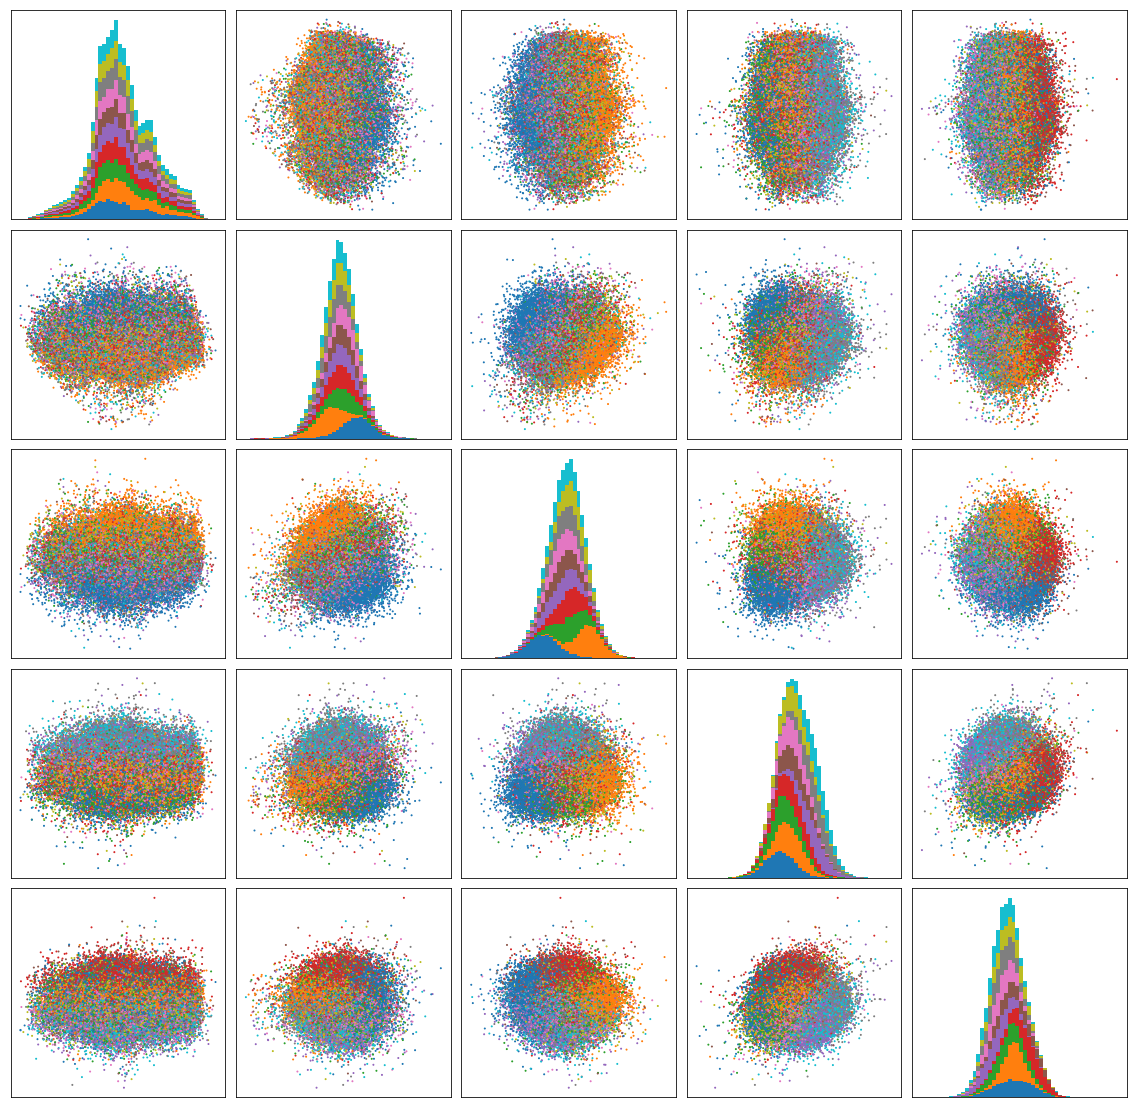

In [11]:
DU.show_splom(X @ Xu[:,:5], labels=Xlab, width=20)

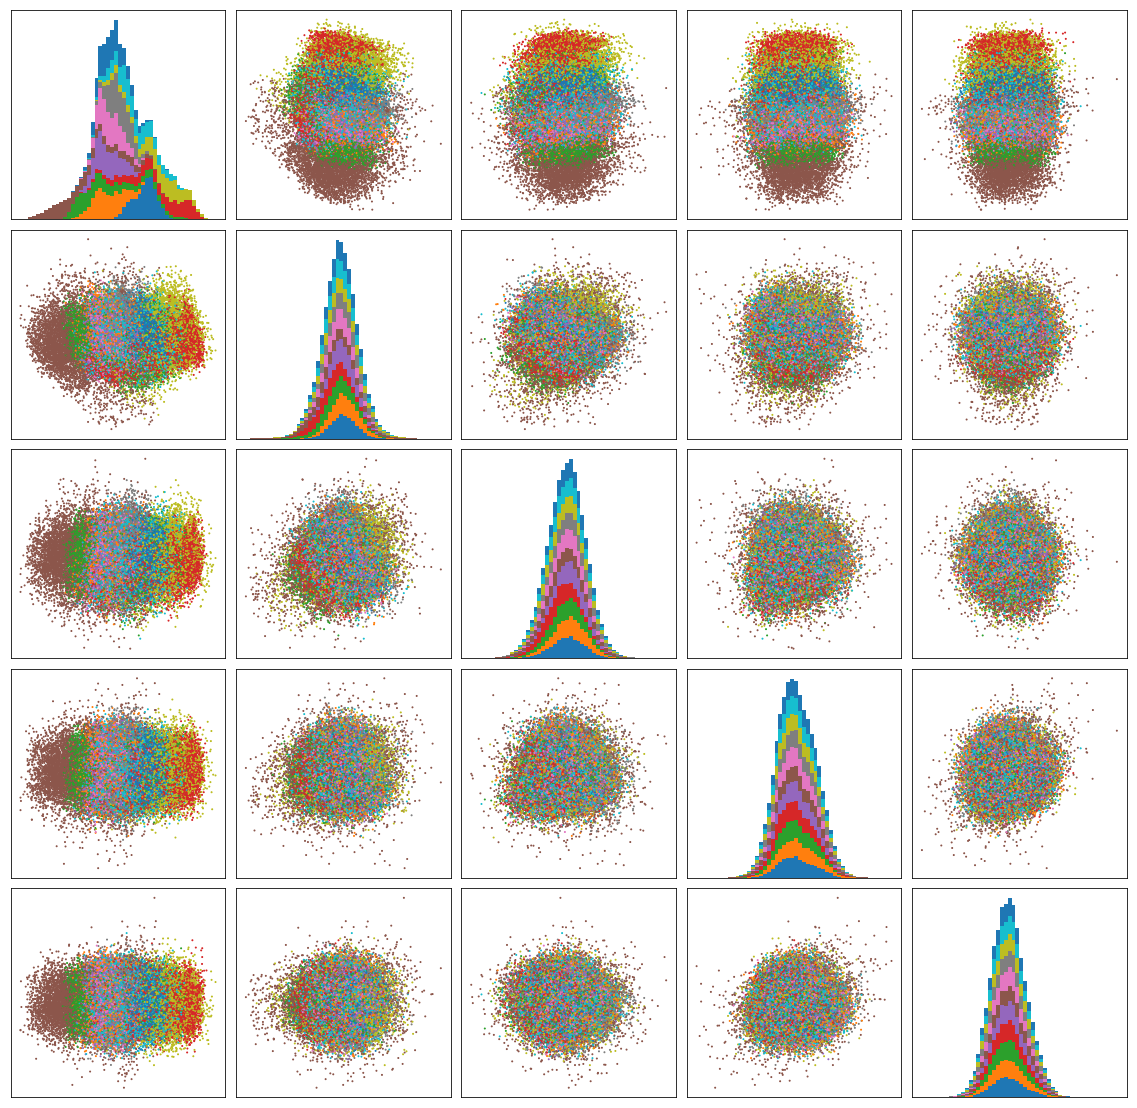

In [15]:
DU.show_splom(X @ Xu[:,:5], labels=Blab, width=20)

### Isomap

We compare the Isomap embeddings of the data when projected into the first $k$ principal components.

Due to slow runtimes for Isomap on large datasets, we limit the number of points to `20,000`.

In [7]:
nsamp = 20000
Xsamp = X[:nsamp]

In [8]:
%cache isomap_mixed_pca5 = DU.isomap_embedding(Xsamp @ Xu[:,:5])
%cache isomap_mixed_pca10 = DU.isomap_embedding(Xsamp @ Xu[:,:10])
%cache isomap_mixed_pca20 = DU.isomap_embedding(Xsamp @ Xu[:,:20])
%cache isomap_mixed_pca50 = DU.isomap_embedding(Xsamp @ Xu[:,:50])
%cache isomap_mixed_pca100 = DU.isomap_embedding(Xsamp @ Xu[:,:100])
%cache isomap_mixed_all = DU.isomap_embedding(Xsamp)

loading cached value for variable 'isomap_grass_pca5'. Time since pickling  12:38:09.315550
loading cached value for variable 'isomap_grass_pca10'. Time since pickling  12:31:16.576804
loading cached value for variable 'isomap_grass_pca20'. Time since pickling  12:25:41.127744
loading cached value for variable 'isomap_grass_pca50'. Time since pickling  12:03:47.042786
loading cached value for variable 'isomap_grass_pca100'. Time since pickling  12:13:10.049572
loading cached value for variable 'isomap_grass_all'. Time since pickling  11:48:20.648236


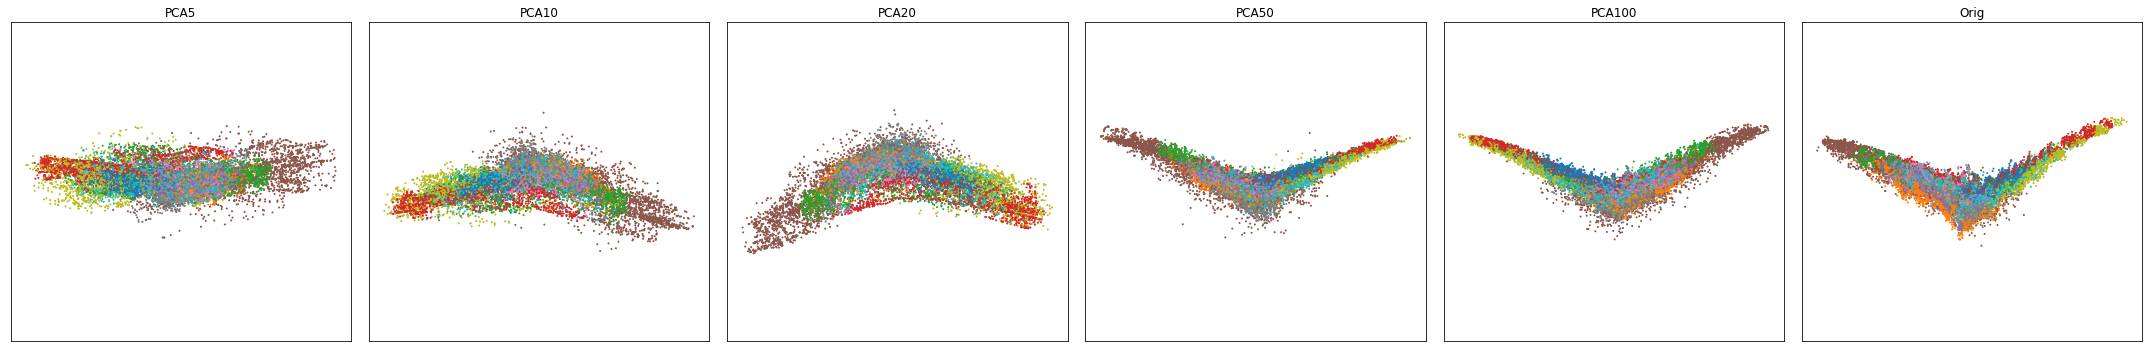

In [9]:
DU.show_embeddings(
    [isomap_mixed_pca5, isomap_mixed_pca10, isomap_mixed_pca20, isomap_mixed_pca50, isomap_mixed_pca100, isomap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

In [ ]:
DU.show_embeddings(
    [isomap_mixed_pca5, isomap_mixed_pca10, isomap_mixed_pca20, isomap_mixed_pca50, isomap_mixed_pca100, isomap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab[:nsamp]
)

There is little variation across the images provided.  This, combined with the large clouds of overlapping points, suggests that Isomap is not capable representing the manifold in a way which clusters the MNIST digits.

### Modified Locally Linear (Modified LLE)

Next, we look at PCA projections of the data using LLE.

As with Isomap, we will restrict the data to `20,000` samples to reduce runtime.

In [10]:
%cache mlle_mixed_pca5 = DU.mlle_embedding(Xsamp @ Xu[:,:5])
%cache mlle_mixed_pca10 = DU.mlle_embedding(Xsamp @ Xu[:,:10])
%cache mlle_mixed_pca20 = DU.mlle_embedding(Xsamp @ Xu[:,:20])
%cache mlle_mixed_pca50 = DU.mlle_embedding(Xsamp @ Xu[:,:50])
%cache mlle_mixed_pca100 = DU.mlle_embedding(Xsamp @ Xu[:,:100])
%cache mlle_mixed_all = DU.mlle_embedding(Xsamp)

loading cached value for variable 'mlle_grass_pca5'. Time since pickling  11:47:03.449466
loading cached value for variable 'mlle_grass_pca10'. Time since pickling  11:44:26.099934
loading cached value for variable 'mlle_grass_pca20'. Time since pickling  11:40:04.574765
loading cached value for variable 'mlle_grass_pca50'. Time since pickling  11:35:12.365411
loading cached value for variable 'mlle_grass_pca100'. Time since pickling  11:31:14.599326
loading cached value for variable 'mlle_grass_all'. Time since pickling  11:22:30.514434


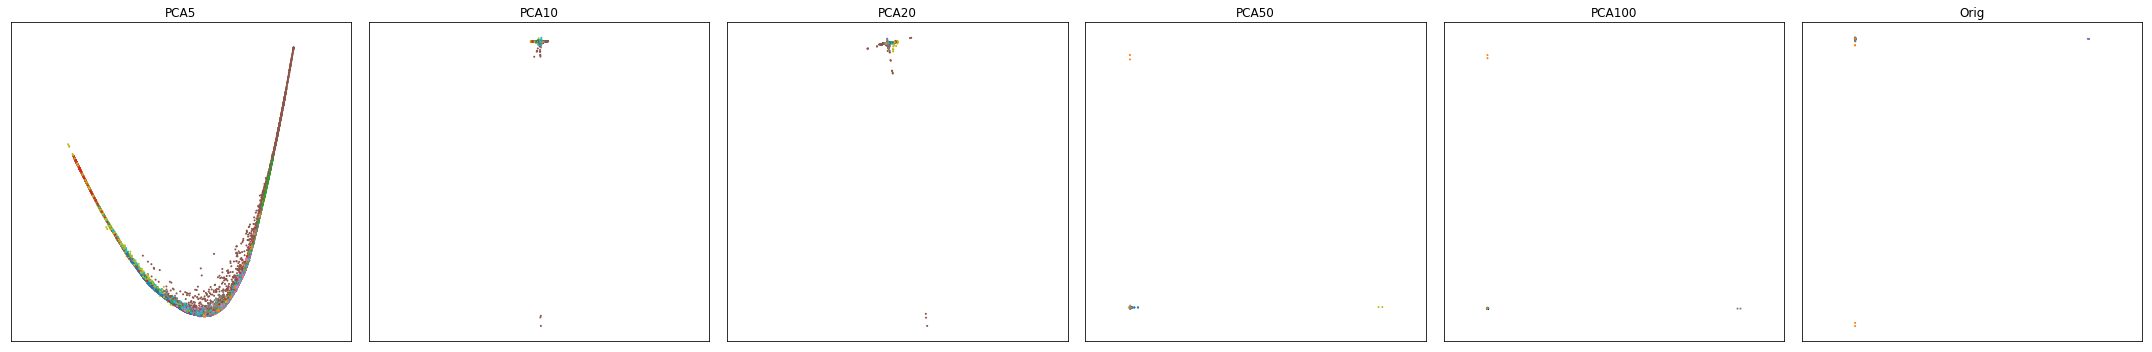

In [11]:
DU.show_embeddings(
    [mlle_mixed_pca5, mlle_mixed_pca10, mlle_mixed_pca20, mlle_mixed_pca50, mlle_mixed_pca100, mlle_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

In [ ]:
DU.show_embeddings(
    [mlle_mixed_pca5, mlle_mixed_pca10, mlle_mixed_pca20, mlle_mixed_pca50, mlle_mixed_pca100, mlle_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab[:nsamp]
)

Modified LLE produces similar embeddings when using 20 or more dimensions.  Although the shape of the embedding is crowded, and does not make efficient use of screen real estate, we can see that several of the MNIST digits are organized into separate areas, with some shared boundaries and overlap.

### Student-T Stochastic Neighbor (t-SNE)



In [12]:
%cache tsne_mixed_pca5 = DU.tsne_embedding(X @ Xu[:,:5])
%cache tsne_mixed_pca10 = DU.tsne_embedding(X @ Xu[:,:10])
%cache tsne_mixed_pca20 = DU.tsne_embedding(X @ Xu[:,:20])
%cache tsne_mixed_pca50 = DU.tsne_embedding(X @ Xu[:,:50])
%cache tsne_mixed_pca100 = DU.tsne_embedding(X @ Xu[:,:100])
%cache tsne_mixed_all = DU.tsne_embedding(X)

loading cached value for variable 'tsne_grass_pca5'. Time since pickling  11:08:15.079453
loading cached value for variable 'tsne_grass_pca10'. Time since pickling  10:53:38.534643
loading cached value for variable 'tsne_grass_pca20'. Time since pickling  10:37:44.937763
loading cached value for variable 'tsne_grass_pca50'. Time since pickling  10:18:35.408197
loading cached value for variable 'tsne_grass_pca100'. Time since pickling  9:54:27.313364
loading cached value for variable 'tsne_grass_all'. Time since pickling  7:55:27.574931


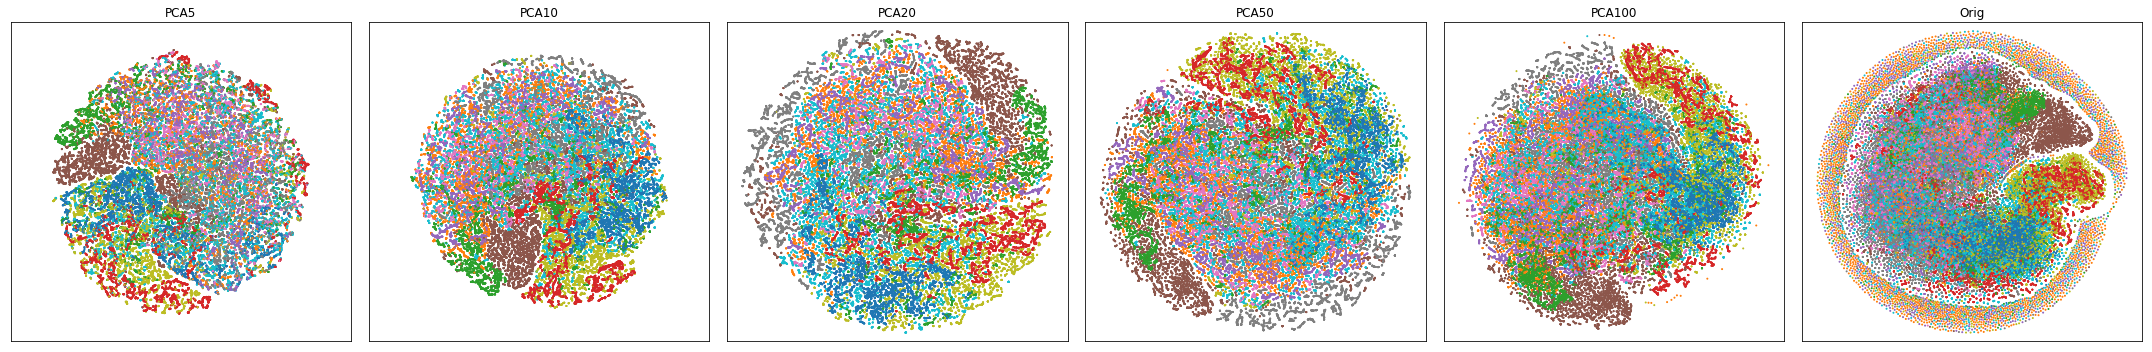

In [13]:
DU.show_embeddings(
    [tsne_mixed_pca5, tsne_mixed_pca10, tsne_mixed_pca20, tsne_mixed_pca50, tsne_mixed_pca100, tsne_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

In [ ]:
DU.show_embeddings(
    [tsne_mixed_pca5, tsne_mixed_pca10, tsne_mixed_pca20, tsne_mixed_pca50, tsne_mixed_pca100, tsne_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab
)

The t-SNE embeddings show clear improvement through 5, 10, and 20 PCA dimensions.  At 50 dimensions we see distinct clusters for all 10 digits, with fairly good separation between clusters.  Additional dimensions offer no discernable improvement.

### Uniform Manifold Approximation and Projection (UMAP)

Here, we look at same PCA projections of the data using UMAP.

In [12]:
%cache umap_mixed_pca5 = DU.umap_embedding(X @ Xu[:,:5], n_neighbors=30)
%cache umap_mixed_pca10 = DU.umap_embedding(X @ Xu[:,:10], n_neighbors=30)
%cache umap_mixed_pca20 = DU.umap_embedding(X @ Xu[:,:20], n_neighbors=30)
%cache umap_mixed_pca50 = DU.umap_embedding(X @ Xu[:,:50], n_neighbors=30)
%cache umap_mixed_pca100 = DU.umap_embedding(X @ Xu[:,:100], n_neighbors=30)
%cache umap_mixed_all = DU.umap_embedding(X, n_neighbors=30)

creating new value for variable 'umap_mixed_pca5'
creating new value for variable 'umap_mixed_pca10'
creating new value for variable 'umap_mixed_pca20'
creating new value for variable 'umap_mixed_pca50'
creating new value for variable 'umap_mixed_pca100'
creating new value for variable 'umap_mixed_all'


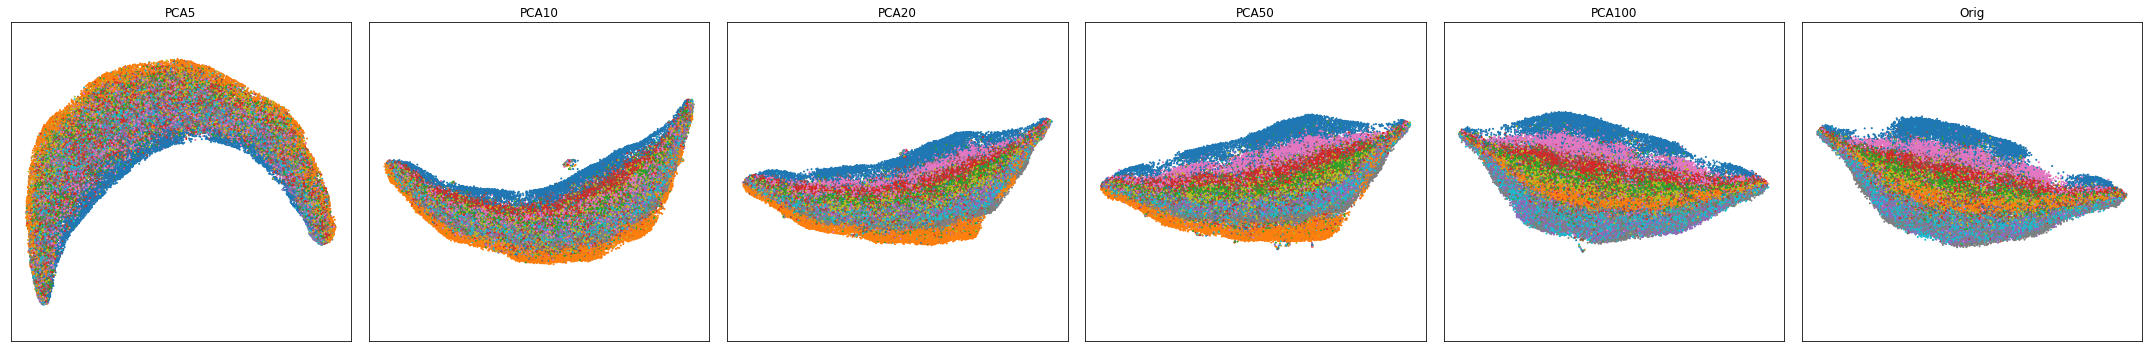

In [13]:
DU.show_embeddings(
    [umap_mixed_pca5, umap_mixed_pca10, umap_mixed_pca20, umap_mixed_pca50, umap_mixed_pca100, umap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

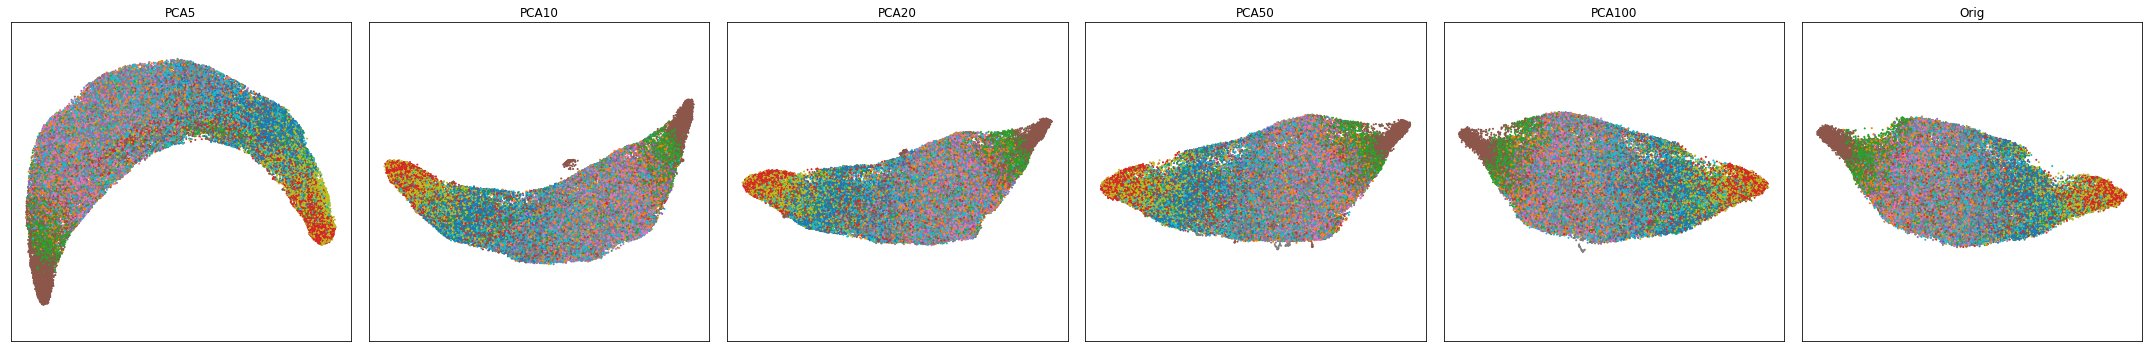

In [14]:
DU.show_embeddings(
    [umap_mixed_pca5, umap_mixed_pca10, umap_mixed_pca20, umap_mixed_pca50, umap_mixed_pca100, umap_mixed_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Blab
)

The UMAP embeddings appear to do the best job of representing the manifold in two dimensions.  Based on the compactness and separation of visible clusters, UMAP validates our earlier understanding of the manifold and subspace.

## Conclusion

MNIST data lies on a manifold which is able to reveal clusters for each of the separate digits.  To an acceptable degree of approximation, this manifold lies within a **50-D subspace**.


In [16]:
%cache